# Gender and Age Recognition from Audio

## Dataset
The dataset used in this project is derived from Mozilla Common Voice, which provides a large collection of speech data contributed by volunteers. The dataset has been preprocessed to ensure balanced representation of male and female genders for improved model performance. [Mozilla Common Voice](https://commonvoice.mozilla.org/en/)

**Columns used**
- `filename`: Path to the audio file
- `gender`: Encoded as 0 for male, 1 for female (others are discarded)
- `age`: Mapped categorical values like “twenties” → 20, “thirties” → 30, etc.

---

## Data Cleaning and Balancing
Dropped Columns: `up_votes`, `down_votes`, `accent`, `duration`, `text`

**Filtering:**
- Removes rows where gender or age is `NaN`.
- Converts textual age groups to numerical values.
- Removes samples labeled as 'other' gender to maintain binary classification.

**Balancing:**
- To avoid gender bias, the dataset is balanced by downsampling the overrepresented gender based on age distribution.

---

## Data Preprocessing

**Sampling Parameters (Default Values)**
- Sample Rate: `22050 Hz`
- Clip Duration: `5 seconds`
- Target Size: `5 * 22050` = `110250` samples

**Audio Preprocessing Pipeline**
- Audio files are loaded using `librosa.load()`.
- Each audio sample is cropped (randomly or center for test set) to 5 seconds (110,250 samples) with padding for shorter clips.
- MFCC (Mel-frequency cepstral coefficients) features are extracted using `librosa.feature.mfcc()`
- Features are standardized using mean and standard deviation to improve convergence during training.

**Dataset Creation**

- TensorFlow Dataset API is used to create efficient data pipelines using `tf.data.Dataset`
- Batches of `256` samples are created
- Training data is shuffled and cached for performance
- Test data uses center cropping instead of random cropping for consistency

---

## Model Architecture

The model combines CNN and RNN architectures for effective audio feature extraction:

**Input Layer**
- Input shape `(n_mfcc, time)` is determined by the MFCC features (varies based on audio length and feature extraction parameters)

**Convolutional Layers**
- First Conv1D: `32` filters with `3×1` kernel, stride `1`
- Second Conv1D: `64` filters with `3×1` kernel, stride `1`
- Third Conv1D: `128` filters with `3×1` kernel, stride `1`
- Each convolutional layer is followed by **batch normalization** and **ReLU** activation

**Recurrent Layer**
- **GRU** layer with `128` units processes temporal information in the sequence

**Output Layers**
- Flatten layer to convert features to 1D
- Gender output: Dense layer with **sigmoid** activation (binary classification)
- Age output: Dense layer with **linear** activation (regression)

---

## Model Training

The training approach uses a multi-task learning setup:

**Loss Functions**
- Gender prediction: **Binary Cross-Entropy** loss (classification task)
- Age prediction: **Mean Squared Logarithmic (MSLE)** Error (regression task). Suitable due to age being positive, wide-ranged and possibly skewed
- Loss weights: Equal weighting (0.5 for each task), balances influence from classification and regression

**Optimizer**
- **Adam Optimizer** with **learning_rate** = `0.0001`.
- Chosen for adaptive learning and stability in noisy gradients common in audio data

**Metrics:**
- **Accuracy** for gender
- **MeanAbsoluteError** for age — interpretable in years


**Epochs**: `30`

**Batch Size**: `256`

**Steps Per Epoch**: Computed from dataset size

**Prefetch and Cache**: Ensures efficient GPU/TPU usage during training

Model performance is validated on a separate test set

Validation is performed after each epoch

---

In [ ]:
!pip install librosa matplotlib seaborn pandas

In [ ]:
import matplotlib.pyplot as plt
import plotly.express as px
import tensorflow as tf
from tqdm import tqdm
import pandas as pd
import numpy as np
import librosa

2025-05-15 09:26:59.022503: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747301219.195164      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747301219.243917      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


---
## Pre-Processing and loading dataset

**Dataset used:** [Mozilla Common Voice](https://commonvoice.mozilla.org/en/)

**Kaggle Link:** [Click Here](https://www.kaggle.com/datasets/mozillaorg/common-voice)

In [ ]:
def balance_data(df):
    gender_counts = df['gender'].value_counts()
    gender_0_count = gender_counts[0]
    gender_1_count = gender_counts[1]
    excess_count = max(gender_0_count - gender_1_count, 0)
    if excess_count > 0:
        gender_0_df = df[df['gender'] == 0]
        sampled_gender_0_df = gender_0_df.sample(n=excess_count, weights=df['age'], replace=False)
        df = pd.concat([df[df['gender'] == 1], sampled_gender_0_df])
    return df


def clean_csv(data, files_folder, is_train):
    data = data.dropna(subset=['age', 'gender']).drop(columns=['up_votes', 'down_votes', 'accent', 'duration', 'text'])
    data["age"] = data["age"].map(
        {"teens": 10, "twenties": 20, "thirties": 30, "fourties": 40, "fifties": 50, "sixties": 60, "seventies": 70,
         "eighties": 80}).infer_objects(copy=False)
    data['filename'] = files_folder + '/' + data['filename']
    data['gender'] = data['gender'].map({'male': 0, 'female': 1, 'other': 2})
    if is_train:
        data = balance_data(data)
    return data[data['gender'] != 2]


def open_csv(folder_path, is_train):
    df = clean_csv(pd.read_csv(folder_path + ".csv"), folder_path, is_train)
    print("Dataframe: " + str(df.shape) + " \n" + str(df['gender'].value_counts()) + str(df['age'].value_counts()))
    px.bar(df.groupby(['age', 'gender']).agg({'filename': 'count'}).reset_index(), x="age", y="filename",
           color="gender", text_auto=True).update_xaxes(categoryorder="total descending").show()
    return df

In [ ]:
dataset_path = "/kaggle/input/common-voice/"

train_df = open_csv(dataset_path + 'cv-valid-train', is_train=True)
test_df = open_csv(dataset_path + 'cv-valid-test', is_train=False)

Dataframe: (54593, 3) 
gender
0    36494
1    18099
Name: count, dtype: int64age
20    14139
30    14056
40     9108
50     8733
60     4314
10     2469
70     1549
80      225
Name: count, dtype: int64


Dataframe: (1523, 3) 
gender
0    1133
1     390
Name: count, dtype: int64age
20    456
30    387
40    231
50    205
10    116
60     87
70     36
80      5
Name: count, dtype: int64


In [ ]:
# Define Constants

BATCH_SIZE = 256
SAMPLE_RATE = 22050
TARGET_SIZE = int(5 * SAMPLE_RATE)

Pre - Processing

In [ ]:
def random_crop(data, center_crop=False):
    """Center crop or randomly crop the audio to target size"""
    N = data.shape[0]
    if N == TARGET_SIZE:
        return data
    if N < TARGET_SIZE:
        tot_pads = TARGET_SIZE - N
        left_pads = int(np.ceil(tot_pads / 2))
        right_pads = int(np.floor(tot_pads / 2))
        return np.pad(data, [left_pads, right_pads], mode='constant')
    if center_crop:
        from_ = int((N / 2) - (TARGET_SIZE / 2))
    else:
        from_ = np.random.randint(0, np.floor(N - TARGET_SIZE))
    to_ = from_ + TARGET_SIZE
    return data[from_:to_]


def normalize(features):
    return (features - np.mean(features, axis=0)) / np.std(features, axis=0)


def load_and_preprocess(df, center_crop):
    result = []
    for file in tqdm(df['filename'].values):
        wf, sr = librosa.load(file) # wave form, sample rate
        wf = random_crop(wf, center_crop)
        wf = librosa.feature.mfcc(y=wf, sr=sr) # MFCC features extraction
        wf = normalize(wf)
        result.append(wf)
    return result

In [ ]:
def create_dataset(dataframe, batch_size=BATCH_SIZE, center_crop=False, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((load_and_preprocess(dataframe, center_crop), (
    dataframe['gender'].values.astype(int), dataframe['age'].values.astype(float))))
    dataset = dataset.cache()
    if shuffle:
        dataset = dataset.shuffle(buffer_size=dataset.cardinality())
    dataset = dataset.repeat()
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset

In [ ]:
train_ds = create_dataset(train_df)
test_ds = create_dataset(test_df, center_crop=True, shuffle=False)

100%|██████████| 54593/54593 [26:30<00:00, 34.33it/s]
I0000 00:00:1747302859.969708      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1747302859.970411      35 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
100%|██████████| 1523/1523 [00:45<00:00, 33.51it/s]


Age: 20.0 | Gender: Male


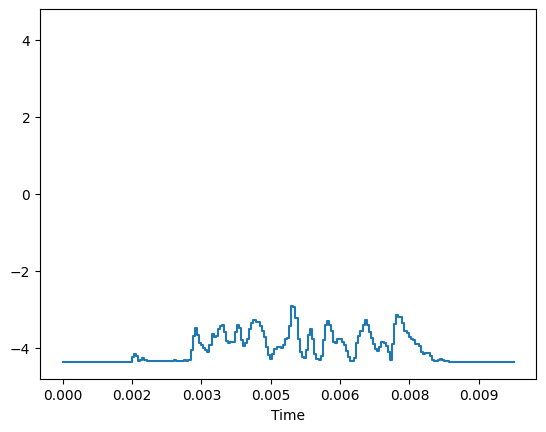

In [ ]:
# .take(1) takes the first batch, .as_numpy_iterator() converts to numpy arrays , .next()gets the first (and only) element
ds = test_ds.take(1).as_numpy_iterator().next()
# ds contains (features, (gender_labels, age_labels)) for the first batch
index = np.random.randint(0, BATCH_SIZE, (1,))[0] # choose random sample from batch
librosa.display.waveshow(ds[0][index])
print(f"Age: {ds[1][1][index]} | Gender: {'Male' if ds[1][0][index] == 0 else 'Female'}")

inp_shape = ds[0][0].shape

In [ ]:
train_steps = int(np.ceil(len(train_df) / BATCH_SIZE))
test_steps = int(np.ceil(len(test_df) / BATCH_SIZE))

---
## CRNN Model Architecture

In [ ]:
class CustomCRNN:

    # CNN blocks capture local patterns like pitch change
    # GRU layer captures the long term dependencies, temporal dynamics
    def __CustomCRNN(self, input_shape):
        X_input = tf.keras.Input(input_shape)
        X = tf.keras.layers.Conv1D(32, 3, strides=1)(X_input) # kernal size = 3
        X = tf.keras.layers.BatchNormalization(axis=-1)(X)
        X = tf.keras.layers.Activation('relu')(X)

        X = tf.keras.layers.Conv1D(64, 3, strides=1)(X)
        X = tf.keras.layers.BatchNormalization(axis=-1)(X)
        X = tf.keras.layers.Activation('relu')(X)

        X = tf.keras.layers.Conv1D(128, 3, strides=1)(X)
        X = tf.keras.layers.BatchNormalization(axis=-1)(X)
        X = tf.keras.layers.Activation('relu')(X)

        X = tf.keras.layers.GRU(128)(X)
        return tf.keras.Model(inputs=X_input, outputs=X, name='CustomCRNN-FeatureExtractor')

    def create_model(self, input_shape):
        base_model = self.__CustomCRNN(input_shape=input_shape)
        fc = tf.keras.layers.Flatten()(base_model.output)

        # Gender output
        gender_output = tf.keras.layers.Dense(1, activation='sigmoid', name='gender_output')(fc)

        #Age output
        age_output = tf.keras.layers.Dense(1, activation='linear', name='age_output')(fc)

        return tf.keras.models.Model(inputs=base_model.input, outputs=[gender_output, age_output], name='CustomCRNN')

In [ ]:
customcrnn = CustomCRNN().create_model(input_shape=inp_shape)

customcrnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                   loss=[tf.keras.losses.BinaryCrossentropy(from_logits=False),
                         tf.keras.losses.MeanSquaredLogarithmicError()],
                   metrics=[['accuracy'], [tf.keras.metrics.MeanAbsoluteError()]],
                   loss_weights=[0.5, 0.5])

customcrnn.summary()

Model: "CustomCRNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 20, 216)        │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d (Conv1D)           │ (None, 18, 32)         │         20,768 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 18, 32)         │            128 │ conv1d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 18, 32)         │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_1 (Conv1D)         │ (None, 16, 64)         │          6,208 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 16, 64)         │            256 │ conv1d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 16, 64)         │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1d_2 (Conv1D)         │ (None, 14, 128)        │         24,704 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 14, 128)        │            512 │ conv1d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 14, 128)        │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gru (GRU)                 │ (None, 128)            │         99,072 │ activation_2[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 128)            │              0 │ gru[0][0]              │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ gender_output (Dense)     │ (None, 1)              │            129 │ flatten[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ age_output (Dense)        │ (None, 1)              │            129 │ flatten[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 151,906 (593.38 KB)

 Trainable params: 151,458 (591.63 KB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
customcrnn_history = customcrnn.fit(train_ds, epochs=30, validation_data=test_ds, steps_per_epoch=train_steps,
                                    validation_steps=test_steps, verbose='auto')

Epoch 1/30


I0000 00:00:1747302937.152971     123 cuda_dnn.cc:529] Loaded cuDNN version 90300


214/214 ━━━━━━━━━━━━━━━━━━━━ 12s 14ms/step - age_output_loss: 5.8237 - age_output_mean_absolute_error: 31.0451 - gender_output_accuracy: 0.6561 - gender_output_loss: 0.6441 - loss: 3.2339 - val_age_output_loss: 0.9431 - val_age_output_mean_absolute_error: 20.8550 - val_gender_output_accuracy: 0.7461 - val_gender_output_loss: 0.5747 - val_loss: 0.7589
Epoch 2/30
214/214 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - age_output_loss: 0.8406 - age_output_mean_absolute_error: 21.6577 - gender_output_accuracy: 0.6644 - gender_output_loss: 0.6145 - loss: 0.7275 - val_age_output_loss: 0.5942 - val_age_output_mean_absolute_error: 17.9417 - val_gender_output_accuracy: 0.7461 - val_gender_output_loss: 0.5385 - val_loss: 0.5663
Epoch 3/30
214/214 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - age_output_loss: 0.6523 - age_output_mean_absolute_error: 19.8508 - gender_output_accuracy: 0.6992 - gender_output_loss: 0.5574 - loss: 0.6049 - val_age_output_loss: 0.4955 - val_age_output_mean_absolute_error: 16.6932 - val_gend

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, mean_absolute_error
import seaborn as sns

In [ ]:
# 1. Collect predictions from the test dataset
y_true_gender, y_pred_gender = [], []
y_true_age, y_pred_age = [], []

for batch in test_ds.take(test_steps):
    X, (genders, ages) = batch
    gender_preds, age_preds = customcrnn.predict(X, verbose=0)

    gender_preds = (gender_preds > 0.5).astype(int).flatten()
    y_pred_gender.extend(gender_preds)
    y_true_gender.extend(genders.numpy().astype(int))

    y_pred_age.extend(age_preds.flatten())
    y_true_age.extend(ages.numpy().flatten())

y_true_gender = np.array(y_true_gender)
y_pred_gender = np.array(y_pred_gender)
y_true_age = np.array(y_true_age)
y_pred_age = np.array(y_pred_age)
print("🔍 Gender Classification Report:\n")
print(classification_report(y_true_gender, y_pred_gender, target_names=["Male", "Female"]))

🔍 Gender Classification Report:

              precision    recall  f1-score   support

        Male       0.90      0.88      0.89      1146
      Female       0.66      0.70      0.68       390

    accuracy                           0.83      1536
   macro avg       0.78      0.79      0.78      1536
weighted avg       0.84      0.83      0.83      1536



🧮 Confusion Matrix (Gender):


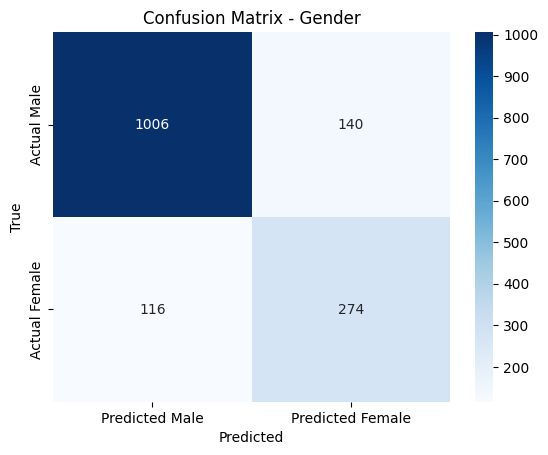

In [ ]:
print("🧮 Confusion Matrix (Gender):")
cm = confusion_matrix(y_true_gender, y_pred_gender)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=["Predicted Male", "Predicted Female"],
            yticklabels=["Actual Male", "Actual Female"], cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix - Gender")
plt.show()


📊 Age Prediction Performance:
Mean Absolute Error (MAE): 12.03


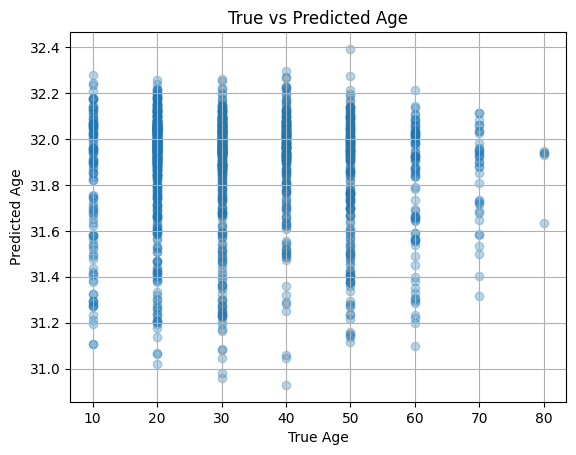

In [ ]:
print(f"\n📊 Age Prediction Performance:")
print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_true_age, y_pred_age):.2f}")

# Optionally, plot true vs predicted ages
plt.scatter(y_true_age, y_pred_age, alpha=0.3)
plt.xlabel("True Age")
plt.ylabel("Predicted Age")
plt.title("True vs Predicted Age")
plt.grid(True)
plt.show()

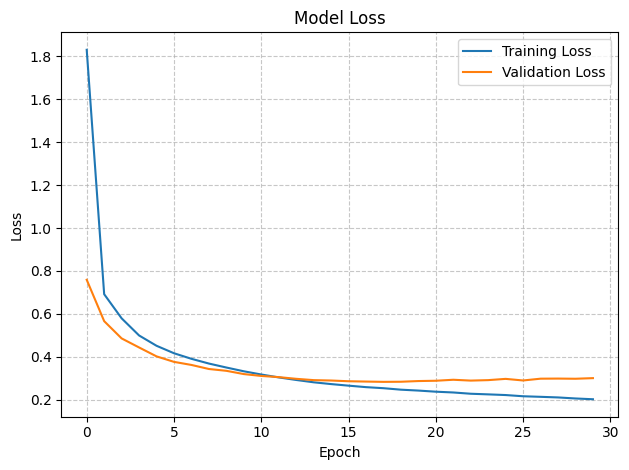

In [ ]:
plt.plot(customcrnn_history.history['loss'], label='Training Loss')
plt.plot(customcrnn_history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

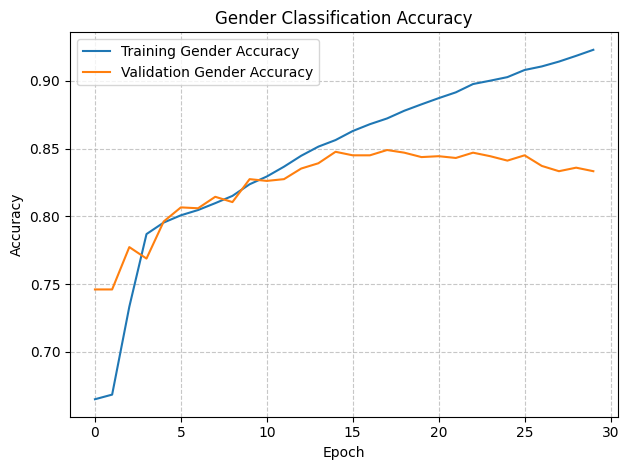

In [ ]:
plt.plot(customcrnn_history.history['gender_output_accuracy'], label='Training Gender Accuracy')
plt.plot(customcrnn_history.history['val_gender_output_accuracy'], label='Validation Gender Accuracy')
plt.title('Gender Classification Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

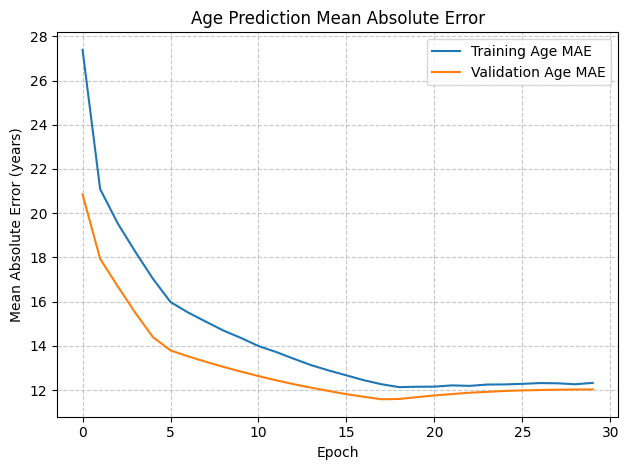

In [ ]:
plt.plot(customcrnn_history.history['age_output_mean_absolute_error'], label='Training Age MAE')
plt.plot(customcrnn_history.history['val_age_output_mean_absolute_error'], label='Validation Age MAE')
plt.title('Age Prediction Mean Absolute Error')
plt.ylabel('Mean Absolute Error (years)')
plt.xlabel('Epoch')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [ ]:
import os

os.makedirs('/kaggle/working/trained-model', exist_ok=True)
customcrnn.save('/kaggle/working/trained-model/customcrnn.keras', overwrite=True, save_format=None)

In [ ]:
# Zip the model directory for easier downloading
!cd /kaggle/working && tar -czf trained-model.tar.gz trained-model/

---
## Prediction using pre-trained model

To use your own audio file:
1. Record a audio clip of around 5 seconds. (can be larger, it will be clipped automatically)
2. Use a online audio converting tool like [Audio converter](https://online-audio-converter.com/) to convert your audio file to `.wav`.
3. Use the advance settings to change the **channels** to `1`
4. (Optional) Change the  **sample rate** to whatever you set below or during training (Default: `22050`).
5. Run the cells below and you will be asked to upload the audio file.

In [ ]:
import librosa.display
import seaborn as sns
from google.colab import files
import os
import warnings
from IPython.display import Audio, display

warnings.filterwarnings('ignore')

In [ ]:
BATCH_SIZE = 256
SAMPLE_RATE = 22050
TARGET_SIZE = int(5 * SAMPLE_RATE)


def random_crop(data, center_crop=False):
    """Center crop or randomly crop the audio to target size"""
    N = data.shape[0]
    if N == TARGET_SIZE:
        return data
    if N < TARGET_SIZE:
        tot_pads = TARGET_SIZE - N
        left_pads = int(np.ceil(tot_pads / 2))
        right_pads = int(np.floor(tot_pads / 2))
        return np.pad(data, [left_pads, right_pads], mode='constant')
    if center_crop:
        from_ = int((N / 2) - (TARGET_SIZE / 2))
    else:
        from_ = np.random.randint(0, np.floor(N - TARGET_SIZE))
    to_ = from_ + TARGET_SIZE
    return data[from_:to_]


def normalize(features):
    return (features - np.mean(features, axis=0)) / np.std(features, axis=0)

In [ ]:
def preprocess_audio_file(file_path):
    """Preprocess an audio file for model input"""
    data, orig_sr = librosa.load(file_path, sr=None)

    if orig_sr != SAMPLE_RATE:
        data = librosa.resample(data, orig_sr=orig_sr, target_sr=SAMPLE_RATE)

    data = random_crop(data, center_crop=True)

    mfcc_features = librosa.feature.mfcc(y=data, sr=SAMPLE_RATE)

    normalized_features = normalize(mfcc_features)

    model_input = np.expand_dims(normalized_features, axis=0)

    return model_input

In [ ]:
# Load the pre trained model from Github

!mkdir -p trained-model
!wget -O /content/trained-model/customcrnn.keras https://github.com/Dilpreet-singh-13/gender-age-prediction-from-audio/raw/refs/heads/main/customcrnn.keras

--2025-05-07 10:56:11--  https://github.com/Dilpreet-singh-13/gender-age-prediction-from-audio/raw/refs/heads/main/customcrnn.keras
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Dilpreet-singh-13/gender-age-prediction-from-audio/refs/heads/main/customcrnn.keras [following]
--2025-05-07 10:56:11--  https://raw.githubusercontent.com/Dilpreet-singh-13/gender-age-prediction-from-audio/refs/heads/main/customcrnn.keras
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1887632 (1.8M) [application/octet-stream]
Saving to: ‘/content/trained-model/customcrnn.keras’

/content/trained-mo 100%[==============

In [ ]:
model_path = '/content/trained-model/customcrnn.keras'
model = tf.keras.models.load_model(model_path)

In [ ]:
def extract_audio_features(audio_file):
    """Extract various audio features for visualization and analysis"""
    y, sr = librosa.load(audio_file, sr=SAMPLE_RATE)

    features = {
        'waveform': y,
        'sr': sr,
        'mfcc': librosa.feature.mfcc(y=y, sr=sr, n_mfcc=20),
        'rms': librosa.feature.rms(y=y)[0],
        'melspectrogram': librosa.feature.melspectrogram(y=y, sr=sr)
    }

    return features, y, sr

In [ ]:
def visualize_audio_features(features, y, sr, filename, gender_pred, age_pred):
    """Create comprehensive visualizations of audio features with 4 plots"""

    fig = plt.figure(figsize=(12, 10))

    gender_label = 'Male' if gender_pred < 0.5 else 'Female'
    gender_percent = round(gender_pred * 100, 2)
    if gender_percent < 45:
        gender_string = "Male"
    elif gender_percent > 55:
        gender_string = "Female"
    else:
        gender_string = "Unknown"

    plt.suptitle(f"Audio Analysis - {filename}\nPredicted Gender: {gender_string}, Predicted Age: {age_pred:.1f}",
                 fontsize=16, y=0.98)

    # 1. Waveform
    ax1 = plt.subplot(2, 2, 1)
    librosa.display.waveshow(y, sr=sr, ax=ax1)
    ax1.set_title('Waveform')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Amplitude')

    # 2. MFCC
    ax2 = plt.subplot(2, 2, 2)
    librosa.display.specshow(features['mfcc'], x_axis='time', ax=ax2)
    ax2.set_title('MFCC Features')
    fig.colorbar(ax2.collections[0], ax=ax2, format='%+2.0f dB', shrink=0.8)

    # 3. Mel Spectrogram (in dB)
    ax3 = plt.subplot(2, 2, 3)
    mel_spec_db = librosa.power_to_db(features['melspectrogram'], ref=np.max)
    img = librosa.display.specshow(mel_spec_db, y_axis='mel', x_axis='time', ax=ax3)
    ax3.set_title('Mel Spectrogram')
    fig.colorbar(img, ax=ax3, format='%+2.0f dB', shrink=0.8)

    # 4. RMS Energy
    ax4 = plt.subplot(2, 2, 4)
    times = librosa.times_like(features['rms'])
    ax4.plot(times, features['rms'], color='green')
    ax4.set_title('RMS Energy')
    ax4.set_xlabel('Time (s)')
    ax4.set_ylabel('Energy')

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    return fig

In [ ]:
def analyze_audio_stats(features, gender_pred, age_pred):
    """Compute statistical properties of the audio features"""
    stats = {
        'gender_label': 'Male' if gender_pred < 0.5 else 'Female',
        'age_prediction': age_pred,
        'mfcc_mean': np.mean(features['mfcc']),
        'mfcc_std': np.std(features['mfcc']),
        'rms_mean': np.mean(features['rms']),
        'rms_std': np.std(features['rms']),
    }
    return stats

In [ ]:
def predict_gender_age(audio_file, visualize=True):
    """Predict gender and age from an audio file with enhanced visualization"""
    input_data = preprocess_audio_file(audio_file)

    prediction = model.predict(input_data, verbose=0)

    # Extract gender and age predictions
    gender_pred = prediction[0][0][0]
    age_pred = prediction[1][0][0]

    gender_percent = round(gender_pred * 100, 2)
    if gender_percent < 45:
        gender = "Male"
    elif gender_percent > 55:
        gender = "Female"
    else:
        gender = "Unknown"

    print(f"Gender: {gender}")
    print(f"Estimated Age: {age_pred:.1f} years")

    if visualize:
        features, y, sr = extract_audio_features(audio_file)

        fig = visualize_audio_features(features, y, sr, os.path.basename(audio_file), gender_pred, age_pred)
        plt.show()

        display(Audio(y, rate=sr))

        stats = analyze_audio_stats(features, gender_pred, age_pred)
        stats_df = pd.DataFrame([stats])

        display_cols = ['gender_label', 'age_prediction',
                       'mfcc_mean', 'rms_mean']
        print("\nAudio Statistics:")
        display(stats_df[display_cols])

    return gender_pred, age_pred, features if visualize else None

In [ ]:
print("Please upload an audio file for analysis...")
uploaded = files.upload()

Please upload an audio file for analysis...


Saving test-audio-wav.wav to test-audio-wav.wav



Analyzing test-audio-wav.wav...
Gender: Male
Estimated Age: 32.2 years


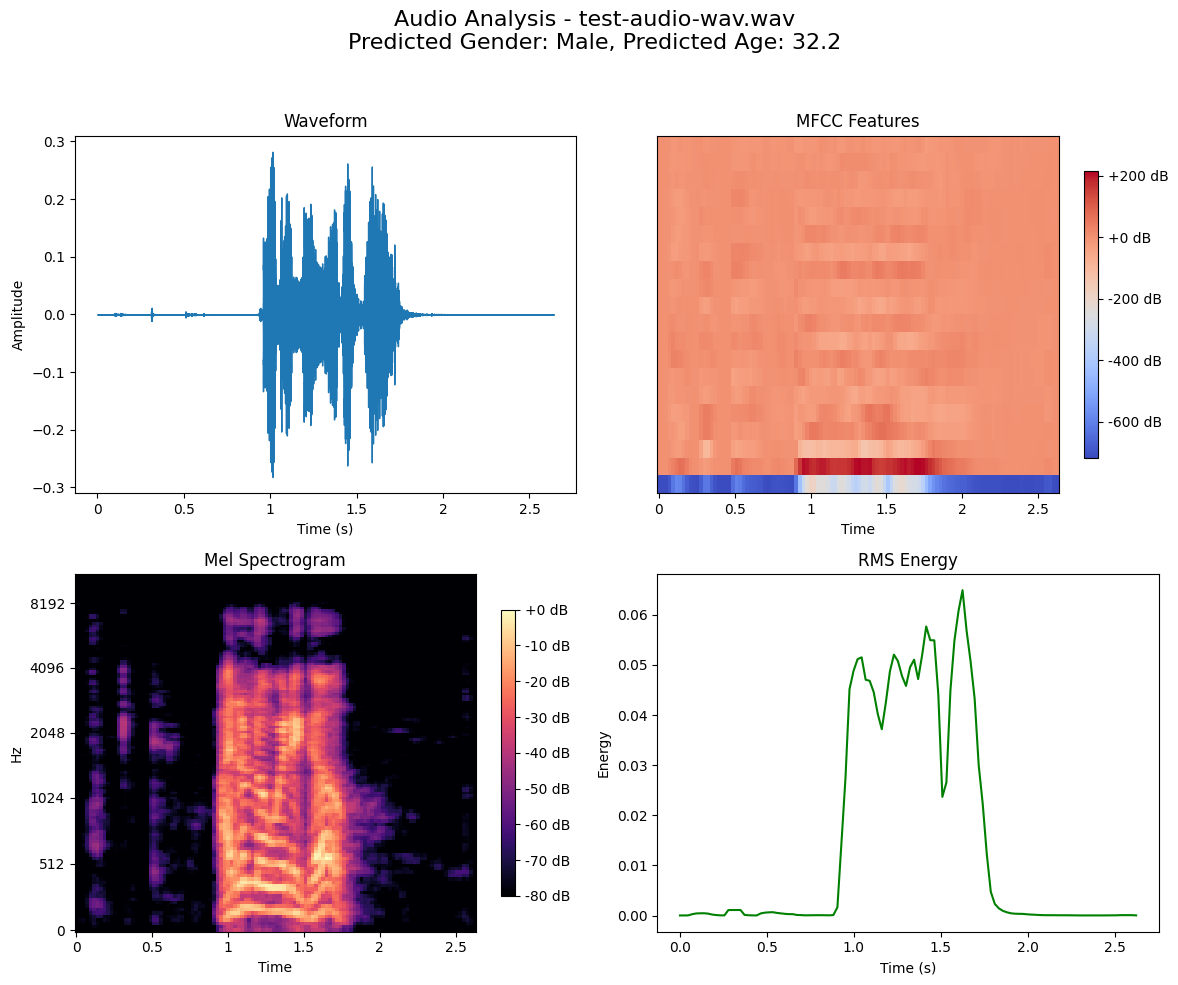


Audio Statistics:


,gender_label,age_prediction,mfcc_mean,rms_mean
0,Male,32.157887,-27.816034,0.014664


In [ ]:
for filename in uploaded.keys():
    print(f"\nAnalyzing {filename}...")
    gender_pred, age_pred, features = predict_gender_age(filename)